In [ ]:
import os
import json
from birdlib import utils
import torch

In [ ]:
with open('/home/giacomoschiavo/finetuning-BirdNET/utils/dataset/dataset_config_augm_final.json') as f:
    dataset_config = json.load(f)

In [12]:
augm = set()
for sample in dataset_config['samples']:
    if 'gain' in sample['file_path']:
        augm.add(sample['file_path'].split('/')[4])
augm

{'Coccothraustes coccothraustes_Hawfinch',
 'Lophophanes cristatus_Crested Tit',
 'Loxia curvirostra_Common Crossbill',
 'Parus major_Great Tit'}

In [13]:
augm = set()
for sample in dataset_config['samples']:
    if 'aug' in sample['file_path']:
        augm.add(sample['file_path'].split('/')[5].split('_')[-1])
augm

{'bn.wav', 'gain.wav', 'psA.wav', 'psB.wav', 'ts.wav'}

In [2]:
TRAIN_PATH = '/home/giacomoschiavo/segments/dataset/train'

In [4]:
def compute_pos_weights(label_counts: dict, class_order: list, n_samples: int, device='cpu'):
    weights = []
    for cls in class_order:
        pos = label_counts[cls]
        neg = n_samples - pos
        w = neg / pos if pos > 0 else 1.0  # evita divisione per zero
        weights.append(w)
    return torch.tensor(weights, dtype=torch.float32).to(device)


In [17]:
# Esempio fittizio
label_counts = { species: len(os.listdir(os.path.join(TRAIN_PATH, species))) for species in os.listdir(TRAIN_PATH)}
counts = torch.tensor(list(label_counts.values()), dtype=torch.float32)
inv_freq = 1.0 / (counts + 1e-6)
pos_weight = inv_freq / inv_freq.mean()  # normalize around 1
names = list(label_counts.keys())
importance_map = {
    'Aeroplane': 0.1,
    'Wind': 0.1,
    'Vegetation': 0.1,
    'None': 0.0,
    # fallback = 1.0
}

importance = torch.tensor([importance_map.get(name, 1.0) for name in names])
final_pos_weight = pos_weight * importance + 1e-3

final_pos_weight, pos_weight, names
for i, name in enumerate(names):
    print(name, final_pos_weight[i])

Aeroplane tensor(0.6789)
Muscicapa striata_Spotted Flycatcher tensor(0.7689)
Periparus ater_Coal Tit tensor(0.3876)
Cuculus canorus_Common Cuckoo tensor(4.6268)
Regulus regulus_Goldcrest tensor(0.4158)
Anthus trivialis_Tree Pipit tensor(0.5896)
Vegetation tensor(0.1773)
Troglodytes troglodytes_Eurasian Wren tensor(0.3246)
Erithacus rubecula_European Robin tensor(0.2322)
None tensor(0.0010)
Parus major_Great Tit tensor(1.0015)
Certhia familiaris_Eurasian Treecreeper tensor(0.6585)
Phylloscopus collybita_Common Chiffchaff tensor(0.1806)
Coccothraustes coccothraustes_Hawfinch tensor(0.9600)
Wind tensor(0.0460)
Turdus merula_Eurasian Blackbird tensor(0.5184)
Loxia curvirostra_Common Crossbill tensor(0.4864)
Regulus ignicapilla_Common Firecrest tensor(0.1311)
Sylvia atricapilla_Eurasian Blackcap tensor(0.1015)
Lophophanes cristatus_Crested Tit tensor(0.5725)
Fringilla coelebs_Common Chaffinch tensor(0.0417)


In [3]:
# tra tutti i file, trova il min e max 'sampling_rate' e 'duration'
min_duration = float('inf')
max_duration = float('-inf')
min_sampling_rate = float('inf')
max_sampling_rate = float('-inf')
count = {}
audio_infos = ['audio_info.json', 'audio_info_2.json', 'audio_info_test.json']
for audio_info in audio_infos:
    with open(f'utils/{audio_info}', 'r') as f:
        data = json.load(f)
        for item in data:
            sampling_rate = data[item]['sampling_rate'] 
            if sampling_rate not in count:
                count[sampling_rate] = 0
            count[sampling_rate] += 1
            sampling_rate = data[item]['sampling_rate']
            duration = data[item]['duration']
            if sampling_rate < min_sampling_rate:
                min_sampling_rate = sampling_rate
            if sampling_rate > max_sampling_rate:
                max_sampling_rate = sampling_rate
            if duration < min_duration:
                min_duration = duration
            if duration > max_duration:
                max_duration = duration
print(f"Min sampling rate: {min_sampling_rate}")    
print(f"Max sampling rate: {max_sampling_rate}")
print(f"Min duration: {min_duration}")
print(f"Max duration: {max_duration}")


Min sampling rate: 22050
Max sampling rate: 48000
Min duration: 2.815419501133787
Max duration: 600.0


Shape dello spettrogramma: torch.Size([256, 256])


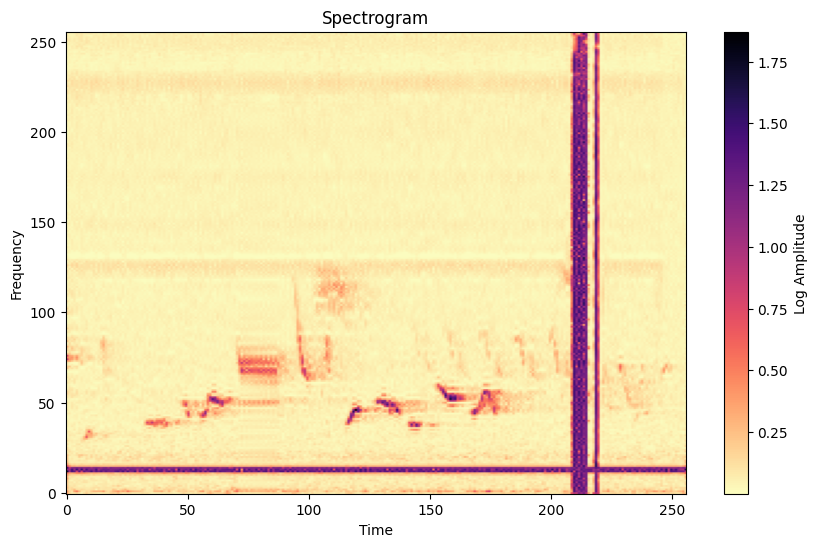

In [5]:
import torch
import matplotlib.pyplot as plt

# Carica lo spettrogramma
spectrogram = torch.load("/home/giacomoschiavo/segments/dataset/train_specs/Muscicapa striata_Spotted Flycatcher/20190621_040000_0_0_aug_spec.pt")

print(f"Shape dello spettrogramma: {spectrogram.shape}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.numpy(), origin="lower", aspect="auto", cmap="magma_r")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Log Amplitude")
plt.show()


# Remove augmented spectrograms

In [6]:
import os
train_specs = '/home/giacomoschiavo/segments/dataset/train_specs'
target_path = '/home/giacomoschiavo/segments/dataset/train_specs_removed'
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_specs):
    for audio in os.listdir(os.path.join(train_specs, species)):
        if 'specaug' in audio:
            os.makedirs(os.path.join(target_path, species), exist_ok=True)
            os.rename(
                os.path.join(train_specs, species, audio),
                os.path.join(target_path, species, audio),
            )